In [1]:
import tensorflow as tf
import numpy as np
from IPython.display import Image
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from datetime import timedelta
import math
import PIL.Image
import random

In [2]:
filter_size_1 = 5
filter_num_1 = 16
filter_size_2 = 5
filter_num_2 = 36
fc_size = 128


In [3]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


In [5]:
data.test.cls = np.argmax(data.test.labels, axis=1)

In [6]:
data.train.images.shape


(55000, 784)

In [8]:
img_size = 28
num_channels = 1
img_size_flat = img_size * img_size 
img_shape = (img_size, img_size,)

num_classes = 10

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

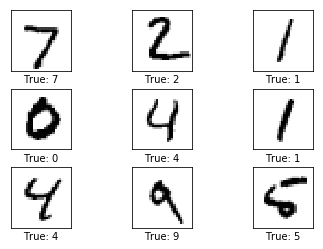

In [10]:
images = data.test.images[0:9]

# Get the true classes for those images.
cls_true = data.test.cls[0:9]


# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

In [64]:
a = np.asarray([1,2,3,4])
b = np.asarray([3,4,5,5])
print(a.shape)
print(b.shape)

c  = np.empty(shape = [2,4,],dtype=int)
c[0] = a
print(c)
c[1] = b
print('updated c',c)

(4,)
(4,)
[[1 2 3 4]
 [0 0 0 0]]
updated c [[1 2 3 4]
 [3 4 5 5]]


In [48]:
c[0] = a
c[1] = b
print(c)
print(c.shape)

[array([1, 2, 3, 4]), array([3, 4, 5, 5])]


AttributeError: 'list' object has no attribute 'shape'

In [11]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [12]:
def new_biases(length):
    #equivalent to y intercept
    #constant value carried over across matrix math
    return tf.Variable(tf.constant(0.05, shape=[length]))

In [13]:
def new_con_layer(input,number_input_channel,filter_size,number_of_filters,use_pooling= True):
    
    shape = [filter_size, filter_size, number_input_channel, number_of_filters]
    weights = new_weights(shape=shape)
    biases = new_biases(length=number_of_filters)
    layer = tf.nn.conv2d(input=input,filter=weights,strides=[1,1,1,1],padding='SAME')
    
    if use_pooling:
        layer = tf.nn.max_pool(layer,strides=[1,2,2,1],ksize=[1,2,2,1],padding='SAME')
        
    layer = tf.nn.relu(layer)
    return layer,weights

    
    

In [14]:
def flatten_layer(input):
    input_shape = input.shape
    num_features = input_shape[1:4].num_elements()
    layer_flat = tf.reshape(input, [-1, num_features])
    return layer_flat,num_features


In [15]:
def fully_connected_layer(input,num_of_input,num_of_output,use_relu =True):
    
    weights = new_weights(shape=[num_of_input, num_of_output])
    biases = new_biases(length=num_of_output)
    layer = tf.matmul(input,weights)+biases
    
    if use_relu:
        layer = tf.nn.relu(layer)
    return layer
                
    

In [16]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])
y_true = tf.placeholder(tf.float32, shape=[None, 10], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)


In [17]:
layer_conv1, weights_conv1 = \
    new_con_layer(input=x_image,
                   number_input_channel=num_channels,
                   filter_size=filter_size_1,
                   number_of_filters=filter_num_1,
                   use_pooling=True)
    

In [18]:
layer_conv1


<tf.Tensor 'Relu:0' shape=(?, 14, 14, 16) dtype=float32>

In [19]:
layer_conv2, weights_conv2 = \
    new_con_layer(input=layer_conv1,
                   number_input_channel=filter_num_1,
                   filter_size=filter_size_2,
                   number_of_filters=filter_num_2,
                   use_pooling=True)

In [20]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 7, 7, 36) dtype=float32>

In [21]:
layer_flatten,number_of_features = flatten_layer(layer_conv2)

In [22]:
print(layer_flatten)
print(number_of_features)

Tensor("Reshape_1:0", shape=(?, 1764), dtype=float32)
1764


In [23]:
layer_fc1 = fully_connected_layer(layer_flatten,number_of_features,fc_size)

In [24]:
layer_fc1

<tf.Tensor 'Relu_2:0' shape=(?, 128) dtype=float32>

In [25]:
layer_fc2 = fully_connected_layer(layer_fc1,fc_size,num_classes,use_relu=False)

In [26]:
layer_fc2

<tf.Tensor 'add_1:0' shape=(?, 10) dtype=float32>

In [27]:
y_pred = tf.nn.softmax(layer_fc2)
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [28]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)
cost = tf.reduce_mean(cross_entropy)

In [29]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.01).minimize(cost)

In [30]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [31]:
session = tf.Session()
session.run(tf.global_variables_initializer())

In [32]:
train_batch_size = 64


In [33]:
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = data.train.next_batch(train_batch_size)
        print(x_batch.shape)
        print(y_true.shape)
        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)

        # Print status every 100 iterations.
        if i % 100 == 0:
            # Calculate the accuracy on the training-set.
            acc = session.run(accuracy, feed_dict=feed_dict_train)

            # Message for printing.
            msg = "Optimization Iteration: {0:>6}, Training Accuracy: {1:>6.1%}"

            # Print it.
            print(msg.format(i + 1, acc))

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [34]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.test.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

In [35]:
def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.test.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

In [36]:
test_batch_size = 256

def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # Number of images in the test-set.
    num_test = len(data.test.images)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_test, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_test:
        # The ending index for the next batch is denoted j.
        j = min(i + test_batch_size, num_test)

        # Get the images from the test-set between index i and j.
        images = data.test.images[i:j, :]

        # Get the associated labels.
        labels = data.test.labels[i:j, :]

        # Create a feed-dict with these images and labels.
        feed_dict = {x: images,
                     y_true: labels}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j

    # Convenience variable for the true class-numbers of the test-set.
    cls_true = data.test.cls

    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    # Calculate the number of correctly classified images.
    # When summing a boolean array, False means 0 and True means 1.
    correct_sum = correct.sum()

    # Classification accuracy is the number of correctly classified
    # images divided by the total number of images in the test-set.
    acc = float(correct_sum) / num_test

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, correct_sum, num_test))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [37]:
print_test_accuracy()

Accuracy on Test-Set: 11.4% (1136 / 10000)


In [38]:
optimize(num_iterations=1)


(64, 784)
(?, 10)
Optimization Iteration:      1, Training Accuracy:  31.2%
Time usage: 0:00:00


In [39]:
print_test_accuracy()

Accuracy on Test-Set: 26.5% (2649 / 10000)


In [40]:
optimize(num_iterations=99) # We already performed 1 iteration above.


(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)
(?, 10)
(64, 784)


Accuracy on Test-Set: 94.0% (9397 / 10000)
Example errors:


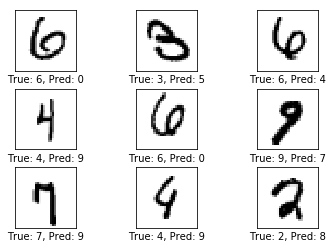

In [41]:
print_test_accuracy(show_example_errors=True)


In [100]:
optimize(num_iterations=900) # We performed 100 iterations above.

Optimization Iteration:   1001, Training Accuracy:  96.9%
Optimization Iteration:   1101, Training Accuracy: 100.0%
Optimization Iteration:   1201, Training Accuracy: 100.0%
Optimization Iteration:   1301, Training Accuracy: 100.0%
Optimization Iteration:   1401, Training Accuracy: 100.0%
Optimization Iteration:   1501, Training Accuracy:  98.4%
Optimization Iteration:   1601, Training Accuracy: 100.0%
Optimization Iteration:   1701, Training Accuracy: 100.0%
Optimization Iteration:   1801, Training Accuracy: 100.0%
Time usage: 0:00:37


Accuracy on Test-Set: 98.4% (9835 / 10000)
Example errors:


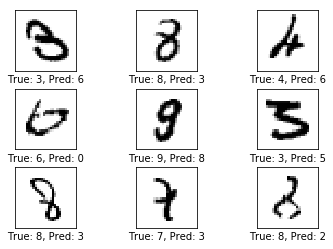

In [101]:
print_test_accuracy(show_example_errors=True)

In [102]:
optimize(num_iterations=9000) # We performed 1000 iterations above.

Optimization Iteration:   1901, Training Accuracy: 100.0%
Optimization Iteration:   2001, Training Accuracy:  98.4%
Optimization Iteration:   2101, Training Accuracy:  96.9%
Optimization Iteration:   2201, Training Accuracy: 100.0%
Optimization Iteration:   2301, Training Accuracy:  98.4%
Optimization Iteration:   2401, Training Accuracy: 100.0%
Optimization Iteration:   2501, Training Accuracy: 100.0%
Optimization Iteration:   2601, Training Accuracy:  98.4%
Optimization Iteration:   2701, Training Accuracy: 100.0%
Optimization Iteration:   2801, Training Accuracy:  98.4%
Optimization Iteration:   2901, Training Accuracy: 100.0%
Optimization Iteration:   3001, Training Accuracy:  98.4%
Optimization Iteration:   3101, Training Accuracy: 100.0%
Optimization Iteration:   3201, Training Accuracy:  98.4%
Optimization Iteration:   3301, Training Accuracy: 100.0%
Optimization Iteration:   3401, Training Accuracy:  96.9%
Optimization Iteration:   3501, Training Accuracy: 100.0%
Optimization I

Accuracy on Test-Set: 98.6% (9855 / 10000)
Example errors:


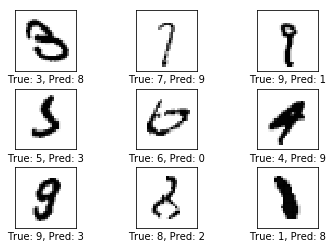

Confusion Matrix:
[[ 975    1    1    0    0    1    1    0    1    0]
 [   0 1130    2    0    0    0    1    0    2    0]
 [   3    0 1023    2    0    0    2    1    1    0]
 [   0    1    0 1004    0    2    0    1    2    0]
 [   0    2    1    0  959    1    3    1    7    8]
 [   1    0    0    5    0  881    1    0    1    3]
 [   4    5    0    0    0    1  945    0    3    0]
 [   0    2    7    3    0    0    0 1010    1    5]
 [   2    3    4    5    0    8    2    2  944    4]
 [   1    6    0    1    3    4    0    4    6  984]]


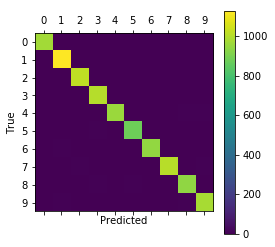

In [103]:
print_test_accuracy(show_confusion_matrix=True,show_example_errors=True)